In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

2024-11-16 08:46:59.450915: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-16 08:46:59.461647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731746819.474230    3325 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731746819.477888    3325 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 08:46:59.492515: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Data preprocessing

In [4]:
import tensorflow as tf
import os

DATASET_DIR = 'aug_dataset' 

# Đường dẫn tới các thư mục lớp
class_names = ['High squamous intra-epithelial lesion', 'Low squamous intra-epithelial lesion', 'Negative for Intraepithelial malignancy', 'Squamous cell carcinoma']
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset cho training và validation
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, 
    subset="training",    
    seed=123,              
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  
    subset="validation",   
    seed=123,              
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)


Found 11544 files belonging to 4 classes.
Using 9236 files for training.


2024-11-16 08:47:01.154526: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 11544 files belonging to 4 classes.
Using 2308 files for validation.


In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(max(1, val_batches // 5))
validation_dataset = validation_dataset.skip(max(1, val_batches // 5))

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 30
Number of test batches: 7


# Configure the dataset for performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Rescale pixel values

In [8]:
# preprocess_input = tf.keras.applications.mobilenet.preprocess_input

In [9]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) # [-1, 1] or [0, 1]

# Create the base model from the pre-trained convnets

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
# Create the base model from the pre-trained model MobileNet
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV3Small(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 576)


# Feature extraction

## Freeze the convolutional base

In [12]:
base_model.trainable = False

In [13]:
base_model.summary()

Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 939,120 (3.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 939,120 (3.58 MB)

## Add a classification head

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 576)


In [15]:
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 4)


In [16]:
inputs = tf.keras.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         2,308 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 941,428 (3.59 MB)

 Trainable params: 2,308 (9.02 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [18]:
len(model.trainable_variables)

2

## Compile the model

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),  # Hoặc SparseCategoricalCrossentropy
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])  # Hoặc SparseCategoricalAccuracy

## Train the model

In [20]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.4070 - loss: 1.2753


In [21]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.27
initial accuracy: 0.41


In [28]:
model_checkpoint = ModelCheckpoint(
    filepath='mobileNet_V3_Small_FE_Aug.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)


In [29]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_duration = end_time - self.start_time
        self.epoch_times.append(epoch_duration)
        print(f"Epoch {epoch + 1} duration: {epoch_duration:.2f} seconds")

In [30]:
time_callback = TimeHistory()

In [31]:
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    callbacks=[model_checkpoint, time_callback]
)

Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.5961 - loss: 1.0582

2024-11-16 08:48:58.154713: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 1: val_loss improved from inf to 0.76734, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 1 duration: 28.00 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step - accuracy: 0.5963 - loss: 1.0576 - val_accuracy: 0.6946 - val_loss: 0.7673
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6791 - loss: 0.8097

2024-11-16 08:49:26.166937: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 2: val_loss improved from 0.76734 to 0.63522, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 2 duration: 27.99 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.6793 - loss: 0.8093 - val_accuracy: 0.7586 - val_loss: 0.6352
Epoch 3/20
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7500 - loss: 0.6709
Epoch 3: val_loss improved from 0.63522 to 0.53459, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 3 duration: 27.92 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 28s 191ms/step - accuracy: 0.7502 - loss: 0.6704 - val_accuracy: 0.8032 - val_loss: 0.5346
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7815 - loss: 0.5842

2024-11-16 08:50:21.464834: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 4: val_loss improved from 0.53459 to 0.48289, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 4 duration: 27.18 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 187ms/step - accuracy: 0.7816 - loss: 0.5840 - val_accuracy: 0.8274 - val_loss: 0.4829
Epoch 5/20
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8092 - loss: 0.5176

2024-11-16 08:50:48.784918: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 5: val_loss improved from 0.48289 to 0.44051, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 5 duration: 27.45 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - accuracy: 0.8094 - loss: 0.5172 - val_accuracy: 0.8457 - val_loss: 0.4405
Epoch 6/20
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8291 - loss: 0.4665

2024-11-16 08:51:16.200308: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 6: val_loss improved from 0.44051 to 0.39742, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 6 duration: 27.38 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 188ms/step - accuracy: 0.8292 - loss: 0.4663 - val_accuracy: 0.8645 - val_loss: 0.3974
Epoch 7/20
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8454 - loss: 0.4319

2024-11-16 08:51:43.200221: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 7: val_loss improved from 0.39742 to 0.36889, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 7 duration: 26.91 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 185ms/step - accuracy: 0.8455 - loss: 0.4317 - val_accuracy: 0.8796 - val_loss: 0.3689
Epoch 8/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8591 - loss: 0.3998

2024-11-16 08:52:10.296232: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 8: val_loss improved from 0.36889 to 0.34718, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 8 duration: 27.11 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 186ms/step - accuracy: 0.8591 - loss: 0.3998 - val_accuracy: 0.8855 - val_loss: 0.3472
Epoch 9/20
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8693 - loss: 0.3720

2024-11-16 08:52:37.526780: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 9: val_loss improved from 0.34718 to 0.33148, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 9 duration: 27.26 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 188ms/step - accuracy: 0.8693 - loss: 0.3719 - val_accuracy: 0.8925 - val_loss: 0.3315
Epoch 10/20
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8780 - loss: 0.3495

2024-11-16 08:53:04.888346: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 10: val_loss improved from 0.33148 to 0.31484, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 10 duration: 27.33 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 188ms/step - accuracy: 0.8780 - loss: 0.3494 - val_accuracy: 0.8968 - val_loss: 0.3148
Epoch 11/20
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8807 - loss: 0.3400

2024-11-16 08:53:33.384206: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 11: val_loss improved from 0.31484 to 0.28739, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 11 duration: 28.50 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 28s 196ms/step - accuracy: 0.8808 - loss: 0.3399 - val_accuracy: 0.9081 - val_loss: 0.2874
Epoch 12/20
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8949 - loss: 0.3136

2024-11-16 08:54:00.689023: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 12: val_loss improved from 0.28739 to 0.27348, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 12 duration: 27.35 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 188ms/step - accuracy: 0.8949 - loss: 0.3135 - val_accuracy: 0.9140 - val_loss: 0.2735
Epoch 13/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8959 - loss: 0.3021

2024-11-16 08:54:28.739641: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 13: val_loss improved from 0.27348 to 0.27274, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 13 duration: 28.10 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.8959 - loss: 0.3021 - val_accuracy: 0.9129 - val_loss: 0.2727
Epoch 14/20
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9033 - loss: 0.2925

2024-11-16 08:54:56.890094: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 14: val_loss improved from 0.27274 to 0.25686, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 14 duration: 28.58 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 29s 196ms/step - accuracy: 0.9034 - loss: 0.2924 - val_accuracy: 0.9194 - val_loss: 0.2569
Epoch 15/20


2024-11-16 08:55:01.994336: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9101 - loss: 0.2785

2024-11-16 08:55:26.384936: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 15: val_loss improved from 0.25686 to 0.24704, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 15 duration: 28.94 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 29s 199ms/step - accuracy: 0.9101 - loss: 0.2784 - val_accuracy: 0.9199 - val_loss: 0.2470
Epoch 16/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9086 - loss: 0.2718

2024-11-16 08:55:54.430507: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 16: val_loss improved from 0.24704 to 0.23839, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 16 duration: 28.66 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 29s 197ms/step - accuracy: 0.9086 - loss: 0.2717 - val_accuracy: 0.9220 - val_loss: 0.2384
Epoch 17/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9136 - loss: 0.2632

2024-11-16 08:56:23.103295: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 17: val_loss improved from 0.23839 to 0.23435, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 17 duration: 28.17 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.9136 - loss: 0.2632 - val_accuracy: 0.9226 - val_loss: 0.2344
Epoch 18/20
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9153 - loss: 0.2520

2024-11-16 08:56:50.563614: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 18: val_loss improved from 0.23435 to 0.22230, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 18 duration: 27.36 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 188ms/step - accuracy: 0.9153 - loss: 0.2520 - val_accuracy: 0.9317 - val_loss: 0.2223
Epoch 19/20


2024-11-16 08:56:55.141578: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9118 - loss: 0.2543

2024-11-16 08:57:18.923863: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 19: val_loss improved from 0.22230 to 0.21482, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 19 duration: 28.58 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 29s 197ms/step - accuracy: 0.9119 - loss: 0.2542 - val_accuracy: 0.9328 - val_loss: 0.2148
Epoch 20/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9225 - loss: 0.2330

2024-11-16 08:57:48.118558: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 20: val_loss improved from 0.21482 to 0.21077, saving model to mobileNet_V3_Small_FE_Aug.keras
Epoch 20 duration: 28.99 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 29s 199ms/step - accuracy: 0.9225 - loss: 0.2330 - val_accuracy: 0.9349 - val_loss: 0.2108


In [32]:
actual_initial_epochs = len(history.epoch) 

In [33]:
actual_initial_epochs

20

## Learning curves

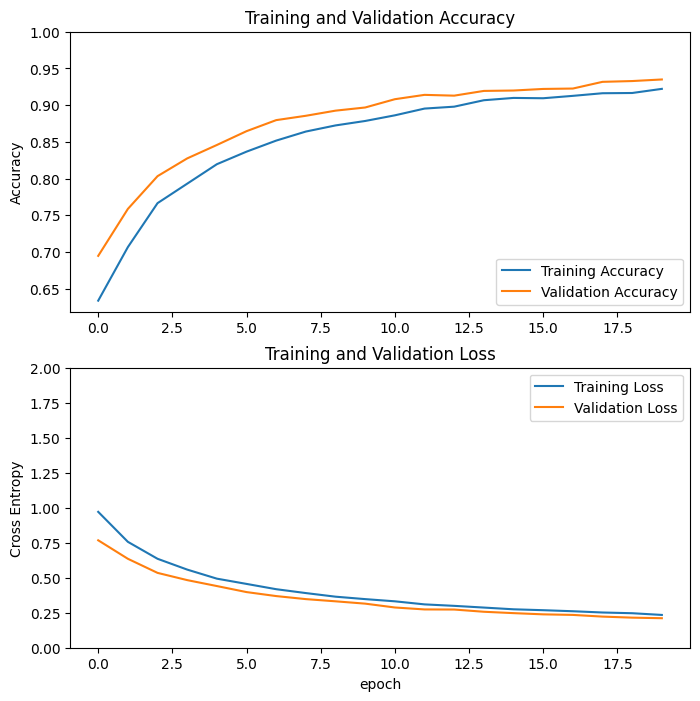

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Time training

### Sum all of epochs


In [38]:
total_time = sum(time_callback.epoch_times)
print(f"Total time for training: {total_time:.2f} seconds")

Total time for training: 557.78 seconds


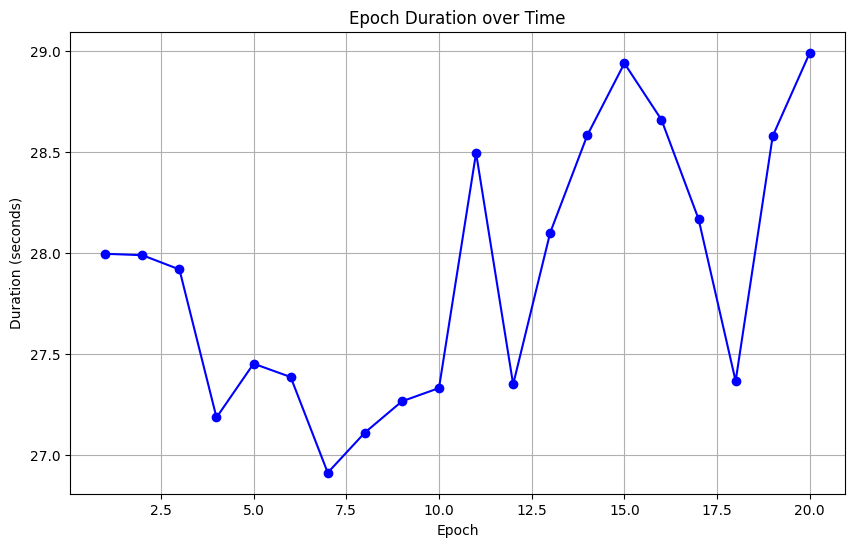

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(time_callback.epoch_times) + 1), time_callback.epoch_times, marker='o', color='b')
plt.title('Epoch Duration over Time')
plt.xlabel('Epoch')
plt.ylabel('Duration (seconds)')
plt.grid(True)
plt.show()

## Evaluate and predict

Model loaded successfully from checkpoint.
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.9154 - loss: 0.2674
Test loss: 0.23719298839569092
Test accuracy: 0.9196428656578064
Predicted classes:
 [2 2 1 2 2 2 2 0 1 2 2 1 2 2 1 2 1 2 2 2 0 0 2 2 2 2 2 2 1 1 2 2 2 2 0 2 0
 2 2 0 0 2 2 2 0 2 2 1 2 2 2 0 2 2 2 2 2 2 2 2 2 0 0 1]
True classes:
 [2 0 1 2 2 2 2 0 1 2 2 1 2 2 1 2 1 2 2 2 0 2 2 2 2 2 2 2 1 1 2 2 2 2 0 2 0
 2 2 0 0 2 2 2 0 2 0 1 2 2 2 0 2 2 2 2 2 2 2 2 1 0 0 1]


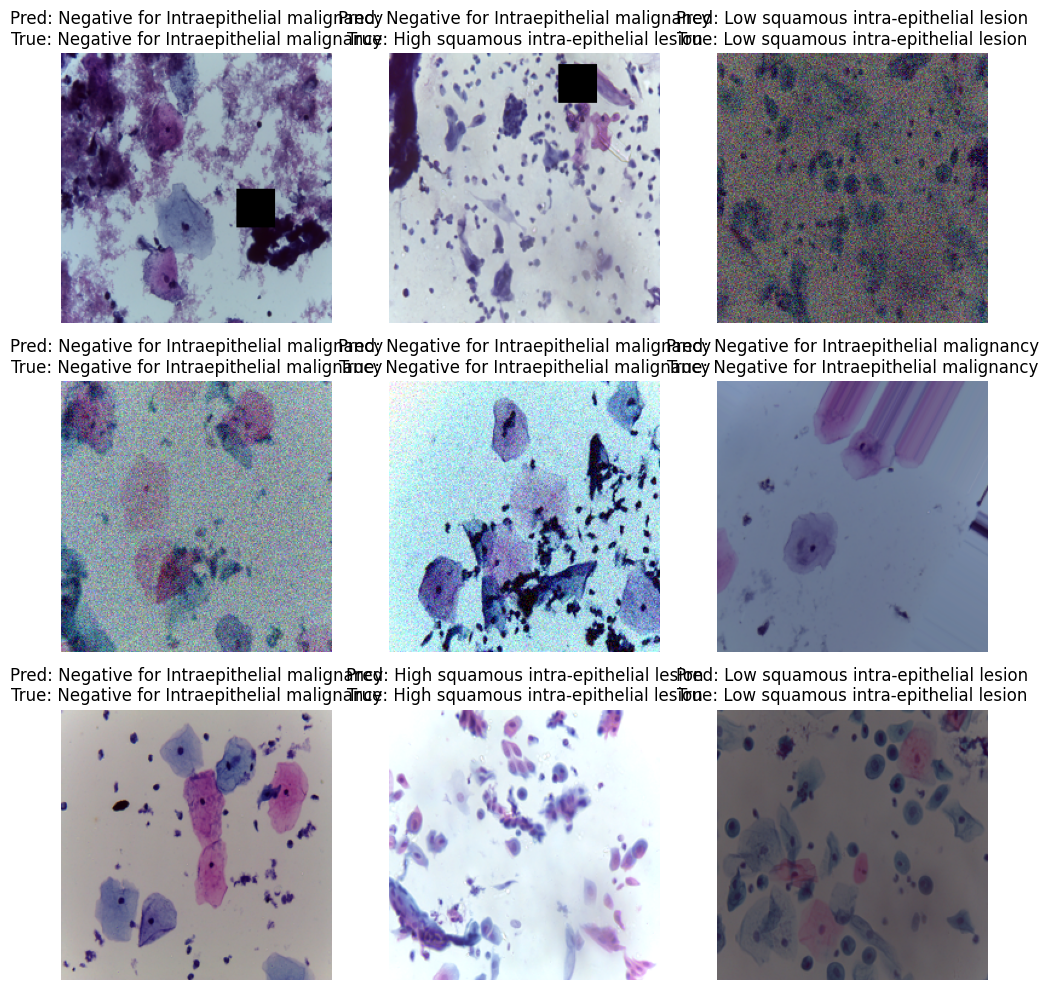

In [40]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Đường dẫn checkpoint
checkpoint_path = 'mobileNet_V3_Small_FE_Aug.keras'

# Load mô hình từ checkpoint
model = tf.keras.models.load_model(checkpoint_path)
print("Model loaded successfully from checkpoint.")

# Evaluate trên tập test
loss, accuracy = model.evaluate(test_dataset)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Lấy một batch ảnh từ tập test
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# Dự đoán trên batch này
predictions = model.predict_on_batch(image_batch)

# Lấy chỉ số lớp dự đoán cao nhất
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(label_batch, axis=1)

# In ra kết quả dự đoán và nhãn thật
print('Predicted classes:\n', predicted_classes)
print('True classes:\n', true_classes)

# Hiển thị hình ảnh với dự đoán
plt.figure(figsize=(10, 10))
for i in range(9):  # Hiển thị 9 ảnh đầu tiên
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"Pred: {class_names[predicted_classes[i]]}\nTrue: {class_names[true_classes[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()
